In [2]:
import mib as mb1
import mib_v2_3_2 as mb
import matplotlib.pyplot as plt
import time
import tracemalloc

# Test 1

## Planteamiento

Comprobar del rendimiento del motor de inferencia con problema pequeño y con tres eventos con distribuciones uniformes, donde su cardinalidad de los tres va de uno a cien.

### Variables

- $A = \{0, 2, ..., n-1\}$

- $B = \{0, 2, ..., n-1\}$

- $C = \{0, 2, ..., n-1\}$

### Modelo de descomposición

$P(ABC) = P(A)P(B|A)P(C|AB)$.

$\;\;\;\;\;\;\;\;\;\;\;\;$<img src="./Imagenes/P(ABC).jpg" width=200/>

### Formas 

$P(A)$, $P(B|A)$ y $P(C|AB)$ serán distribuciones uniformes.

## Test

### MIB1.0

In [ ]:
n = 25
timesM1 = []
memoryM1 = []

timesC1 = []
memoryC1 = []

for i in range(21,22):
    Events = [x for x in range(i+1)]
    # Varaibles
    A = mb1.Var('A',Events)
    B = mb1.Var('B',Events)
    C = mb1.Var('C',Events)

    dA = {}
    dB_A = {}
    dC_AB = []
    value = 1 / (i+1)
    for e in Events:
        dA[e] = value
        dB_A[e] = {}
        for e1 in Events:
            dB_A[e][e1] = value
            tC_AB = []
            for e2 in Events:
                tC_AB.append(value)
            dC_AB.append(tuple(tC_AB))
    
    PA=mb1.Distrib(name='P(A)',variable=[A],tabla=dA)
    PB_A=mb1.DistribCond(name='P(B|A)',var=B,indep=[A],tabla=dB_A)
    PC_AB=mb1.DistribCond('P(C|AB)',C,[A,B],dC_AB)
    
    PABC=mb1.JointDistrib(name='P(ABC)',variables=[A,B,C],descomp=[PA,PB_A,PC_AB])
    Q_ABC=mb1.Question(joint=PABC)

    #Inferencia de P(B)
    tracemalloc.start()
    
    inicio = time.time()
    PB = Q_ABC.query(searched=[B])
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesM1.append(tiempo_ejecucion)
    memoryM1.append(memoria_pico)
    
    #Inferencia de P(A|BC)
    tracemalloc.start()
    
    inicio = time.time()
    PA_BC = Q_ABC.query(searched=[A], known=[B,C])
    fin = time.time() 
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesC1.append(tiempo_ejecucion)
    memoryC1.append(memoria_pico)

### MIB2.0

Complejidad $O(3) = 25^3$

In [46]:
n = 25
timesM = []
memoryM = []

timesC = []
memoryC = []

for i in range(n):
    Events = set([x for x in range(i+1)])
    
    # Generación de distribuciones de probabilidad (Distribuciones uniformes).
    dA = {}
    dB_A = {}
    dC_AB = {}
    value = 1 / (i+1)
    for x in range(i+1):
        dA[(x,)] = value
        dB_A[(x,)] = {}
        for y in range(i+1):
            dB_A[(x,)][(y,)] = value
            dC_AB[(x,y)] = {}
            for z in range(i+1):
                dC_AB[(x,y)][(z,)] = value
    
    # Variables para el motor de inferencia.
    A = mb.Var('A', Events)
    PA = mb.Distrib(dA, (A,))
    B = mb.Var('B', Events)
    PB_A = mb.Distrib(dB_A, (B,), (A,))
    C = mb.Var('C', Events)
    PC_AB = mb.Distrib(dC_AB, (C,), (A,B))
    
    # Probabilidad conjunta (Espesificación)
    PABC = mb.Specification(set([A,B,C]), (PA, PB_A, PC_AB))

    Q_ABC = mb.Question(PABC)
    
    timesM_i = 0
    memoryM_i = 0
    timesC_i = 0
    memoryC_i = 0
    for j in range(5):
        # Inferencia de una distibución marginal
        tracemalloc.start()
        
        inicio = time.time()
        PB = Q_ABC.DistributionQuery(set([B]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesM_i += tiempo_ejecucion
        memoryM_i += memoria_actual
        
        # Inferencia de una distibución condicional 
        tracemalloc.start()
        
        inicio = time.time()
        PA_BC = Q_ABC.DistributionQuery(set([A]), set([B,C]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesC_i += tiempo_ejecucion
        memoryC_i += memoria_actual
    
    timesM.append(timesM_i / 5)
    memoryM.append(memoryM_i / 5)
    timesC.append(timesC_i/ 5)
    memoryC.append(memoryM_i / 5)

## Datos obtenidos

### Tiempos

#### Tiempos de inferencia para $P(B)$

In [ ]:
xn = [i+1 for i in range(n)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
# fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, timesM1[:len(timesM1)-1], color='b',label = 'MIB_1.0')
ax[0].set_title("Tiempo de inferencia para P(B) (MIB_1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("segundos")

# MIB_2.0
ax[1].plot(xn, timesM, color='r',label = 'MIB_2.0')
ax[1].set_title("Tiempo de inferencia para P(B) (MIB_2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("segundos")

# Mostrar las gráficas
plt.show()

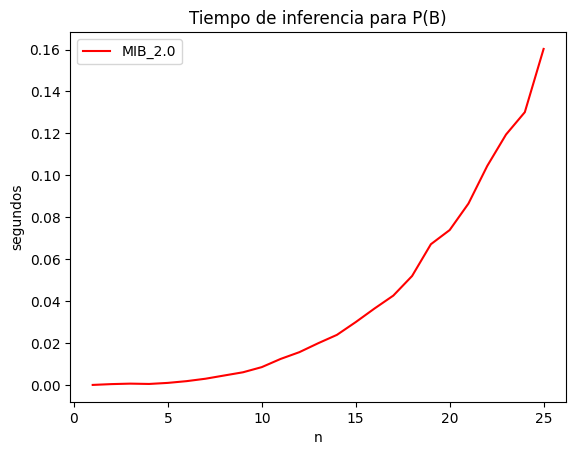

In [47]:
fig, ax = plt.subplots()
xn = [i+1 for i in range(n)]
# MIB_1.0
ax.plot(xn, timesM1, color='b', label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, timesM, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

#### Tiempos de inferencia para $P(C|AB)$

In [ ]:
xn = [i+1 for i in range(n)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
# MIB_1.0
ax[0].plot(xn, timesC1, color='b',label = 'MIB_1.0')
ax[0].set_title("Tiempo de inferencia para P(C|AB) (MIB_1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("segundos")

# MIB_2.0
ax[1].plot(xn, timesC, color='r',label = 'MIB_2.0')
ax[1].set_title("Tiempo de inferencia para P(C|AB) (MIB_2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("segundos")

# Mostrar las gráficas
plt.show()

In [ ]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, timesC1, color='b', label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, timesC, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

### Memoria

#### Memoria para la inferencia de P(B)

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, [m/1000 for m in memoryM1], color='b',label = 'MIB_1.0')
ax[0].set_title("Memoria para la inferencia para P(B) (MIB1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("MB")

# MIB_2.0
ax[1].plot(xn, [m/1000 for m in memoryM], color='r',label = 'MIB_2.0')
ax[1].set_title("Memoria para la inferencia para P(B) (MIB2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("MB")

# Mostrar las gráficas
plt.show()

In [ ]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, [m/1000 for m in memoryM1], color='b',label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, [m/1000 for m in memoryM], color='r',label = 'MIB_2.0')
ax.set_title("Memoria para la inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

#### Memoria para la inferencia de P(C|AB)

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, [m/1000 for m in memoryC1], color='b',label = 'MIB_1.0')
ax[0].set_title("Memoria para la inferencia para P(C|AB) (MIB1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("MB")

# MIB_2.0
ax[1].plot(xn, [m/1000 for m in memoryC], color='r',label = 'MIB_2.0')
ax[1].set_title("Memoria para la inferencia para P(C|AB) (MIB2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("MB")

# Mostrar las gráficas
plt.show()

In [ ]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, [m/1000 for m in memoryC1], color='r',label = 'MIB_1.0')
# MIB_2.0
ax.plot(xn, [m/1000 for m in memoryC], color='b',label = 'MIB_2.0')

ax.set_title("Memoria para la inferencia para P(C|AB)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

# Test 2

## Planteamiento

Comprobar del rendimiento del motor de inferencia n variables binarias.

### Variables

$X = \{X_1, X_2,\dots,X_n\}$, donde $\forall X_i \in X, X_i = \{0,1\}$.

### Modelo de descomposición

$P(X) = P(X_1)P(X_2|X_1)P(X_3|X_1,X_2) \cdots P(X_n|X_1,\dots,X_{n-1})$.

## Test

### MIB1.0

In [7]:
from itertools import product
import mib as mb1
n = 20
timesM = []
memoryM = []
timesC = []
memoryC = []

for i in range(n):
    values = [0,1]
    
    vars =  [mb1.Var('X'+str(j+1), values) for j in range (i+3)]
    
    for j,var in enumerate(vars):
        if j == 0:
            tX1 = {(0,):0.5, (1,):0.5}
            descomp = [mb1.Distrib('P(X1)',[vars[0]], tX1)]
        else:
            for r in range(j):
                tXn = {}
                values_n = [list(xn.values) for xn in vars[:r+1]]
                for key in product(*values_n):
                    tXn[key] = {(0,):0.5, (1,):0.5}
            indep_names_aux = [v.name+',' for v in vars[:j+1]]
            indep_names = ''
            for indep_name in indep_names_aux:
                indep_names += indep_name
            name = 'P(X)'+str(j+2)+'|'+indep_names+')'
            descomp.append(mb1.DistribCond(name,var,vars[:j+1], tXn))
    
    joint_names = [v.name+',' for v in vars]
    joint_name = ''
    for name in joint_names:
        joint_name += name
    PX1Xn = mb1.JointDistrib(joint_name, vars, descomp)
    Q_X1Xn=mb1.Question(joint=PABC)

KeyError: 0

### MIB2.0

Complejidad: $O(n) = 2^n$

$t_m(n) = 2^n * n$

In [3]:
from itertools import product
n = 20
timesM = []
memoryM = []
timesM_A = []
memoryM_A = []
test_n = 10
for i in range(n):
    print(i+1)
    values = set([0,1])
    
    vars = tuple([mb.Var("X"+str(j+1), values) for j in range(i+3)])
    

    for j,var in enumerate(vars):
        if j == 0:
            tX1 = {(0,):0.5, (1,):0.5}
            descomp = [mb.Distrib(tX1, (var,))]
        else:
            for r in range(j):
                tXn = {}
                values_n = [list(xn.values) for xn in vars[:r+1]]
                for key in product(*values_n):
                    tXn[key] = {(0,):0.5, (1,):0.5}
            descomp.append(mb.Distrib(tXn, (var,), tuple(vars[:j]) ))
    
    QX1Xn = mb.Question(mb.Specification(set(vars), tuple(descomp)))
    
    timesM_i = 0
    memoryM_i = 0
    timesM_Ai = 0
    memoryM_Ai = 0
    
    for m in range(test_n):
        print(f"\t{m+1}")
        # Inferencia de una distibución marginal
        """ tracemalloc.start()
        
        inicio = time.time()
        PXn = QX1Xn.DistributionQuery(set([vars[-1]]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        tiempo_ejecucion = fin - inicio
        
        timesM_i += tiempo_ejecucion
        memoryM_i += memoria_actual """
        
        # Aproximación de una distibución marginal
        tracemalloc.start()
        
        inicio = time.time()
        PXn = QX1Xn.DistributionQuery(set([vars[-1]]), aproximation=True)
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        tiempo_ejecucion = fin - inicio
        
        timesM_Ai += tiempo_ejecucion
        memoryM_Ai += memoria_actual
    
    # timesM.append(timesM_i / test_n)
    # memoryM.append(memoryM_i / test_n)
    timesM_A.append(timesM_Ai / test_n)
    memoryM_A.append(memoryM_Ai / test_n)

1
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
2
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
3
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
4
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
5
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
6
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
7
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
8
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
9
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
10
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
11
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
12
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
13
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
14
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
15
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
16
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
17
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
18
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
19
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
20
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10


In [4]:
n = 20
timesC = []
memoryC = []
timesC_A = []
memoryC_A = []

test_n = 10
for i in range(n):
    print(i+1)
    values = set([0,1])
    
    vars = tuple([mb.Var("X"+str(j+1), values) for j in range(i+3)])
    

    for j,var in enumerate(vars):
        if j == 0:
            tX1 = {(0,):0.5, (1,):0.5}
            descomp = [mb.Distrib(tX1, (var,))]
        else:
            for r in range(j):
                tXn = {}
                values_n = [list(xn.values) for xn in vars[:r+1]]
                for key in product(*values_n):
                    tXn[key] = {(0,):0.5, (1,):0.5}
            descomp.append(mb.Distrib(tXn, (var,), tuple(vars[:j]) ))
    
    QX1Xn = mb.Question(mb.Specification(set(vars), tuple(descomp)))
    
    timesC_i = 0
    memoryC_i = 0
    timesC_Ai = 0
    memoryC_Ai = 0
    for m in range(test_n):
        print(f"\t{m+1}")
        # Inferencia de una distibución condicional 
        """ tracemalloc.start()
        
        inicio = time.time()
        PX1_X2Xn = QX1Xn.DistributionQuery(set([vars[0]]), set([vars[1],vars[-1]]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesC_i += tiempo_ejecucion
        memoryC_i += memoria_actual """
        
        # Aproximación de una distibución condicional 
        tracemalloc.start()
        
        inicio = time.time()
        PX1_X2Xn = QX1Xn.DistributionQuery(set([vars[0]]), set([vars[1],vars[-1]]), aproximation=True)
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesC_Ai += tiempo_ejecucion
        memoryC_Ai += memoria_actual
    
    # timesC.append(timesC_i/ test_n)
    # memoryC.append(memoryC_i / test_n)
    timesC_A.append(timesC_Ai/ test_n)
    memoryC_A.append(memoryC_Ai / test_n)
    

1
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
2
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
3
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
4
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
5
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
6
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
7
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
8
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
9
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
10
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
11
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
12
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
13
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
14
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
15
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
16
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
17
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
18
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
19
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
20
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10


In [5]:
import json

""" # Diccionario que deseas guardar
mi_diccionario = {
    "timesM": timesM,
    "timesC": timesC,
    "memoryM": memoryM,
    "memoryC": memoryC
}

# Guardar el diccionario en un archivo JSON
with open("datos_MIB2.json", "w") as archivo_json:
    json.dump(mi_diccionario, archivo_json, indent=4) """
    
# mi_diccionario.clear()
mi_diccionario = {
    "timesM": timesM_A,
    "timesC": timesC_A,
    "memoryM": memoryM_A,
    "memoryC": memoryC_A
}

# Guardar el diccionario en un archivo JSON
with open("datosA_MIB2.json", "w") as archivo_json:
    json.dump(mi_diccionario, archivo_json, indent=4)

In [6]:
with open("datos_MIB2.json", "r") as archivo_json:
    datos = json.load(archivo_json)
datos

{'timesM': [0.00014493465423583984,
  0.00025005340576171874,
  0.0004900217056274414,
  0.000864720344543457,
  0.0018998384475708008,
  0.004308438301086426,
  0.009550333023071289,
  0.021512627601623535,
  0.04999964237213135,
  0.11041824817657471,
  0.26698429584503175,
  0.5420786619186402,
  1.1352542638778687,
  2.3552502632141112,
  5.183044815063477,
  10.583786654472352,
  23.093365573883055,
  48.681302189826965,
  103.61304068565369,
  278.02607760429385],
 'timesC': [0.0006323099136352539,
  0.0015597105026245116,
  0.0029499292373657226,
  0.00586404800415039,
  0.013900852203369141,
  0.03181009292602539,
  0.06378555297851562,
  0.17030539512634277,
  0.3646751642227173,
  0.8547543525695801,
  1.7916800498962402,
  4.831041049957276,
  8.311834979057313,
  12.309812593460084,
  25.768193626403807,
  57.2570859670639,
  119.66406688690185,
  257.81346290111543,
  557.4392376661301,
  1222.1001611709594],
 'memoryM': [912.0,
  176.0,
  206.4,
  188.0,
  216.0,
  296.6,

In [7]:
timesM = datos["timesM"]
timesC = datos["timesC"]
memoryM = datos["memoryM"]
memoryC = datos["memoryC"]

## Datos

In [24]:
def grafica2(list1, list2, title1, title2, xn, x_label, y_label):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12,6)
    ax[0].plot(xn, list1, color='b',label = 'Exacta')
    ax[0].set_title(title1)
    ax[0].set_xlabel(x_label)
    ax[0].set_ylabel(y_label)


    ax[1].plot(xn, list2, color='r',label = 'Aproximación')
    ax[1].set_title(title2)
    ax[1].set_xlabel(x_label)
    ax[1].set_ylabel(y_label)
    
    plt.show()
    

In [9]:
def grafica(list1, list2, label1, label2, title, xn, x_label, y_label):
    fig, ax = plt.subplots()
    ax.plot(xn, list1, color='b', label = label1)

    ax.plot(xn, list2, color='r',label = label2)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc = 'upper left')

    # Mostrar las gráficas
    plt.show()

### Marginal

#### Tiempos

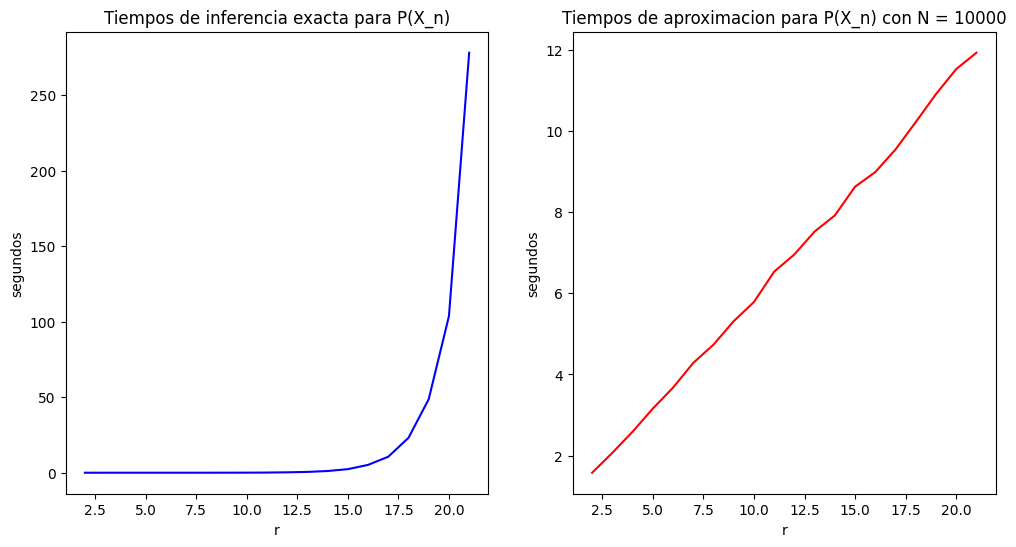

In [30]:
xn = [i+2 for i in range(n)]
title1 = "Tiempos de inferencia exacta para P(X_n)"
title2 = "Tiempos de aproximacion para P(X_n) con N = 10000"
grafica2(timesM, timesM_A, title1, title2, xn, 'r', 'segundos')

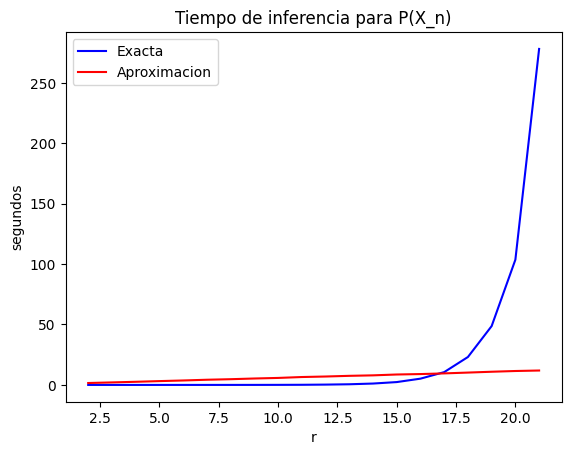

In [31]:
grafica(timesM, timesM_A, 'Exacta', 'Aproximacion', "Tiempo de inferencia para P(X_n)", xn, 'r', 'segundos')

### Condicional 

#### Tiempos

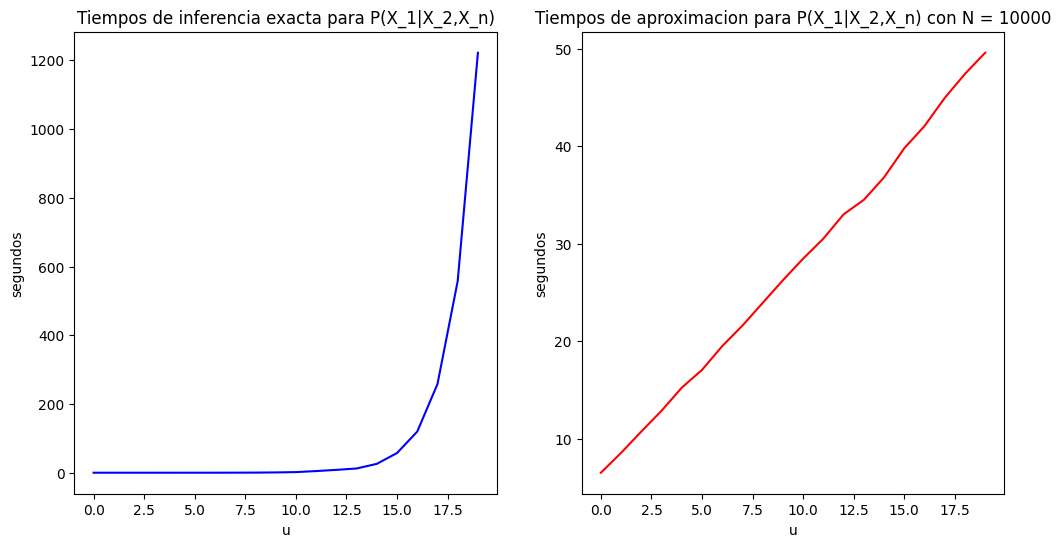

In [28]:
xn = [i for i in range(n)]
title1 = "Tiempos de inferencia exacta para P(X_1|X_2,X_n)"
title2 = "Tiempos de aproximacion para P(X_1|X_2,X_n) con N = 10000"
grafica2(timesC, timesC_A, title1, title2, xn, 'u', 'segundos')

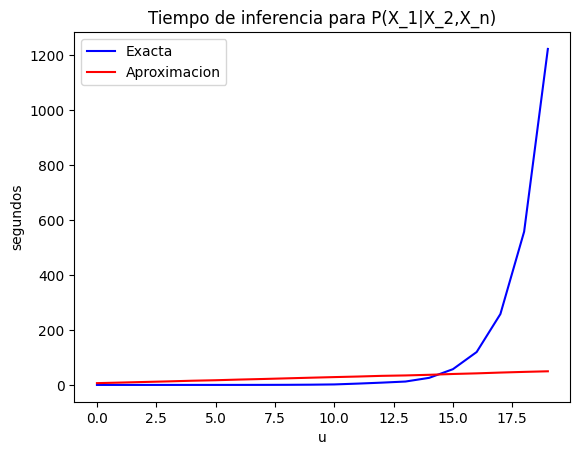

In [29]:
grafica(timesC, timesC_A, 'Exacta', 'Aproximacion', "Tiempo de inferencia para P(X_1|X_2,X_n)", xn, 'u', 'segundos')

# Test 3

Autoria de textos 

## Plantemiento

## Test

### Recolección de datos (ejemplo)

### Test del mib2.0